# Individual Analysis for the M&ouml;ssbauer experiment

## Full analysis template

**This template walks through the analysis starting from the raw MCA spectrum files and associated velocity transducer measurements for each sample.  If you opt to use the LabVIEW data analysis window to obtain the spectrum peak positions and widths, you should use the *Mossbauer Results-Only Analysis* template.**

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

In [223]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
import pandas as pd
%matplotlib inline

### Tasks for this analysis

For each spectrum:

1. Use the peak-to-peak amplitude from the velocity transducer and to create a calibration function (a line).  You will need the function generator period and MCS dwell time.  The function should return a velocity in mm/s given a channel number.  Negative velocities should indicate negative energy shifts, and positive velocities should indicate positive energy shifts.

2. Apply your calibration function to the spectrum data sets for all spectra and plot them.

3. Use LMFit and follow the tutorial on fitting a complicated multi-peak function to a data set to fit the absorption peaks to Lorentzians plus a parabolic (2nd order polynomial) background. (Note: you may, if you wish, fit each peak at a time rather than fit the entire spectrum with one complicated curve.)

4. From the fits, obtain the peak center (with uncertainty) and peak width for each peak in each spectrum.  Record these results in tables, one table for each sample.  

You will use the peak positions in mm/s to complete the data analysis.


### Create the calibration function(s)

Think carefully about the motion of the source: where is it at the begining of the scan?  which direction is it moving? 

Think carefully about the dwell time and how long an MCS cycle takes.  (One cycle is a run through all channels.)  At which channel is the velocity zero?  Which channel would have the highest velocity forward and which would have the highest velocity in reverse.  Once you know this, you create a line that interpolates between these points. 

In [224]:
# Python "dictionary" to hold the peak-to-peak velocity transducer readings, in mV
# You supply values and write the function.

Vpp = {'Fe':48.52, 'Nitroprusside':48.43, 'Fe2O3':21.2}

Vpp['Fe2O3']  # Should print the value for the labeled sample


21.2

#### Write the calibration function

Fill in the details below.


In [225]:
Conversion_const = 0.295 # (mm/s)/mV

def velocity_cal(chan, Vpp=50.0, conv=Conversion_const, dwell=5.0e-4, period=1.00):
    '''
    Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time 
    'dwell' (in s), and the drive period 'period' (in s).  
    '''
    # Start function
    # trigger set to +v_max so max forward speed, (+v_max) is the intercept
    v_max = 0.5 * Vpp * conv
    intercept = v_max
    
    # The slope is the change in v over change in channel. At channel=1000, v=-v_max, we have seen half the period (T/2), 
    channels_per_period = period / dwell
    slope = -2 * v_max / (channels_per_period / 2)
    
    return(intercept + slope*(chan+0.5)) # slight correction to place velocity at middle of dwell time (1/2 channel)

# Test your function as follows

a_channel = 250
print("Velocity at channel {} = {:4g} mm/s".format(a_channel, velocity_cal(a_channel,Vpp=Vpp['Fe'])))


Velocity at channel 250 = 3.57119 mm/s


### Work on the first datafile

Read in the first data file and then apply the calibration to convert channel numbers to velocity.  Plot the result.

**Note:**

The calibration, if done correctly, will flip the x-axis of the data set.  Assuming you are doing this on a column in a Pandas dataframe (the default when you read a csv file with `pd.read_csv()`) then the following will reorder the channel array so that the low index is on the left of the plot and the high index is on the right:

`Fe_velocity = velocity_cal(Fe['Chan'],Vpp['Fe']).sort_values()`

where `velocity_cal()` is the calibration function, `Fe['Chan']` is the data from the **Channel** column and `Vpp['Fe']` is the peak-to-peak voltage from the velocity transducer measurement.  The method attached to the end reorders the array from lowest to highest.

***However I recommend the following.***  Just add another column to the dataframe which holds the converted channels-to-velocity.  This makes it easier to deal with slices of the array.  In other words do this:

`Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])`

Then you can reference the original channels when you need to, but pass the velocity to the fitting routines when you need to get results in mm/s.


#### Read in the data file

The raw data files are tab separated two-column files with a one-line header that does not matter for multichannel scaling files.  You need to skip the header and name the columns to create a dataframe.

Use the **Pandas** `read_csv()` function to read the raw data file from the Norland MCA as follows:

    Fe = pd.read_csv('enriched_Fe_data.txt',header=0,names=['Chan','Counts'],sep='\t')
    
The dataframe will be named `Fe`  with columns `Fe['Chan']` ad `Fe['Counts']`. 

In [226]:
# Read the data in
Fe = pd.read_csv('Fe_counts.csv')
Fe['Chan'] = Fe['Channel']

Make a plot to check that it looks right.

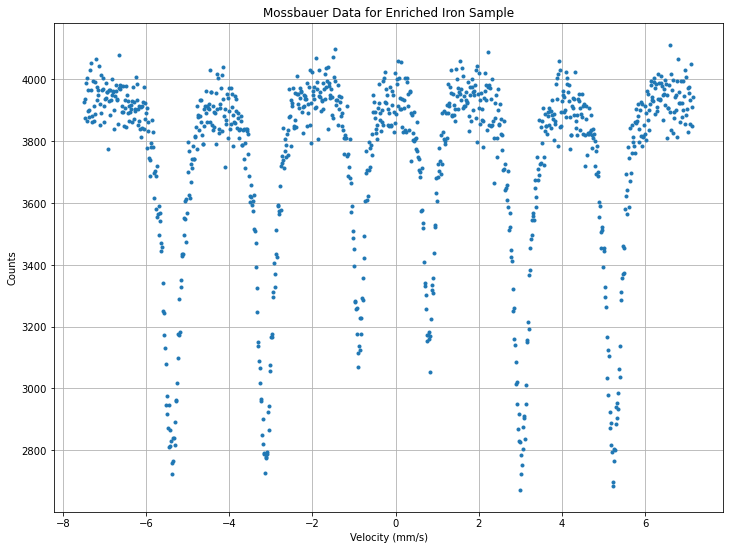

In [227]:
# Create a velocity column, as described above
Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Enriched Iron Sample')
plt.plot(Fe['velocity'],Fe['Counts'],'.');

Next, plot against the column index to be able to estimate a slice.  Take the slice and plot it to check. (these plots do not need to have axis labels, or be particularly big.)

You will also want to plot against the velocity array in order to estimate the fitting parameter start values.

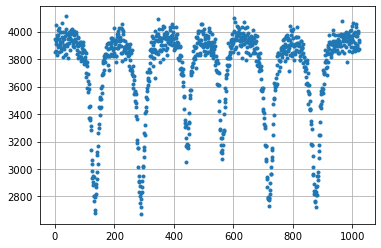

In [228]:
plt.grid()
plt.plot(Fe['Counts'],'.');

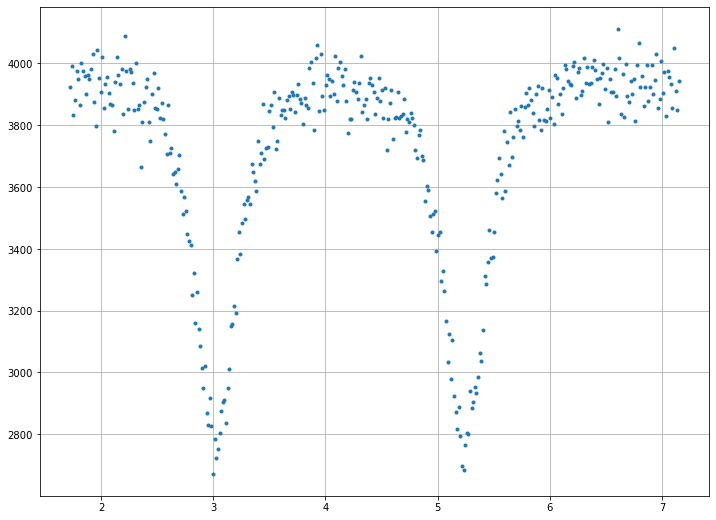

In [229]:
# Slice of peaks 1-2
Index = list(range(0,380))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');

### Fit the slice to the model

Now you should be reday to apply the procedure described in the **Composite Model Demo - Mossbauer** notebook.

Below is a reminder of the basic steps.

### Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$ 

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

In [230]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
model1 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')

model = model1

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


### Set the fit parameter starting points

The first peak is shown as an example.

In [231]:

params['p1_center'].set(value=5.3, vary=True)
params['p1_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params['p1_sigma'].set(value=0.15, vary=True)

params['p2_center'].set(value=3.1, vary=True)
params['p2_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params['p2_sigma'].set(value=0.15, vary=True)


params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 4000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                 4000     True
p1_amplitude     -1885     True
p1_center          5.3     True
p1_fwhm            0.3    False
p1_height        -4000    False
p1_sigma          0.15     True
p2_amplitude     -1885     True
p2_center          3.1     True
p2_fwhm            0.3    False
p2_height        -4000    False
p2_sigma          0.15     True


Then fit.  The code below is an example.  Note the use of wieghts from Poisson statistics of counting and also the commands to resize the plot from the fitting routine.

[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 380
    # variables        = 7
    chi-square         = 412.177385
    reduced chi-square = 1.10503320
    Akaike info crit   = 44.8873686
    Bayesian info crit = 72.4685674
    R-squared          = 0.96553165
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             3991.62698 +/- 5.82181757 (0.15%) (init = 4000)
    p1_amplitude: -828.036920 +/- 17.2376646 (2.08%) (init = -1884.956)
    p1_center:     5.23807506 +/- 0.00298449 (0.06%) (init = 5.3)
    p1_sigma:      0.21305367 +/- 0.00513354 (2.41%) (init = 0.15)
    p2_amplitude: -803.497689 +/- 16.5803048 (2.06%) (init = -1884.956)
    p2_center:     3.01794384 +/- 0.00292418 (0.10%) (init = 3.1)
    p2_sigma:      0.20608512 +/- 0.00495182 (2.40%) (init = 0.15)
    p1_fwhm:       0.42610734 +/

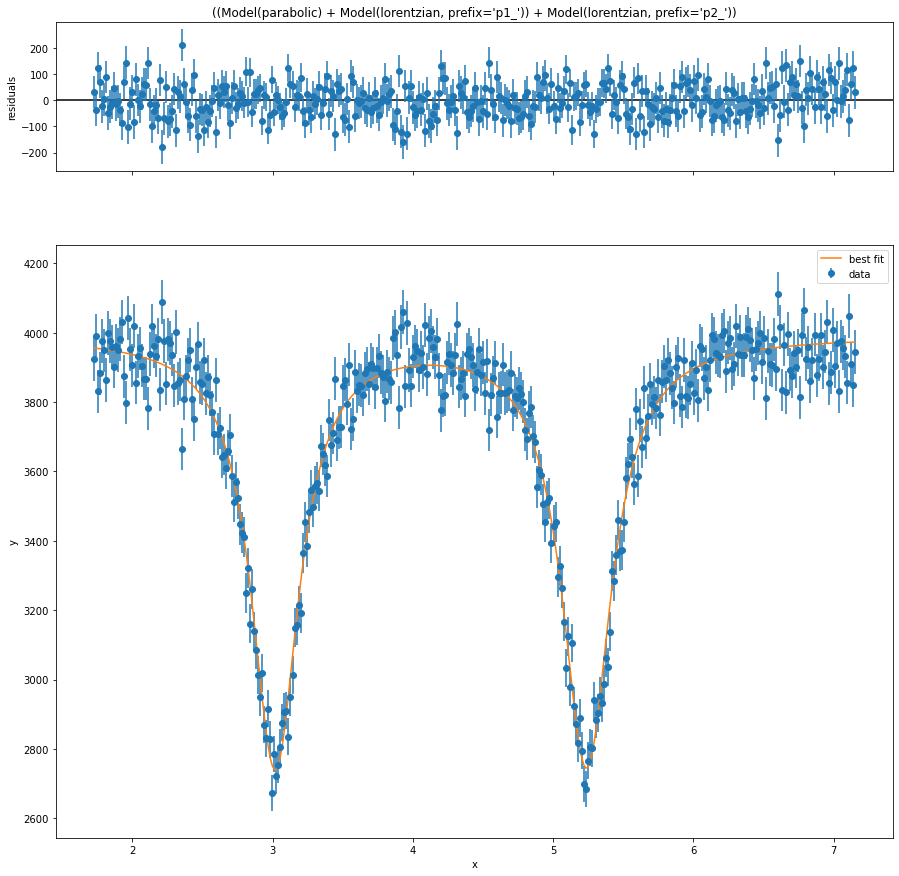

In [232]:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c                 3992    5.822     True
p1_amplitude      -828    17.24     True
p1_center        5.238 0.002984     True
p1_fwhm         0.4261  0.01027    False
p1_height        -1237    16.71    False
p1_sigma        0.2131 0.005134     True
p2_amplitude    -803.5    16.58     True
p2_center        3.018 0.002924     True
p2_fwhm         0.4122 0.009904    False
p2_height        -1241    17.01    False
p2_sigma        0.2061 0.004952     True

Original parameters (not changed):
Name             Value   Stderr     Vary
a                    0     None    False
b                    0     None    False
c                 4000     None     True
p1_amplitude     -1885     None     True
p1_center          5.3     None     True
p1_fwhm            0.3     None    False
p1_height        -4000     None    False
p1_sigma          0.15     None     True
p2_amplitude     -188

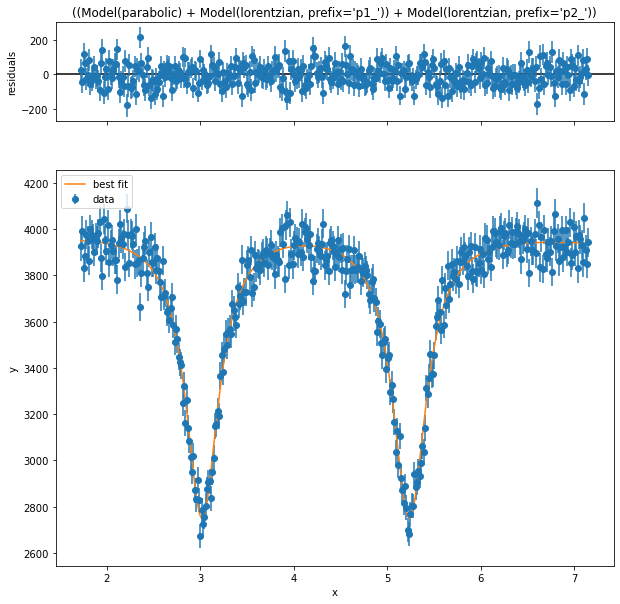

In [233]:
params1 = model_fit.params
params1.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

params1['b'].vary = True
params1['a'].vary = True

model_fit = model.fit(Fe['Counts'][Index], params1, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

#### Have you succeeded with the above?

If not,  try to fix it before mving on. If so, do the following:
1. Save your current parameters
2. Then
   * Add another peak by expanding your slice or
   * Choose a different slice and fit the peaks there
3. Save your parameters and repeat.

Your goal is to get good values of the peak locations.

(When I did it, I added peaks, two at a time, until I got a fit for the whole scan.)

#### Add and Fit Slice 2

In [234]:
# Set second set of start parameters
params1 = model_fit.params

model2 = LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_')

params2 = model2.make_params()

params2['p3_center'].set(value=0.9, vary=True)
params2['p3_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params2['p3_sigma'].set(value=0.15, vary=True)

params2['p4_center'].set(value=-0.9, vary=True)
params2['p4_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params2['p4_sigma'].set(value=0.15, vary=True)

model = model1 + model2

params = params1 + params2

params.pretty_print(columns=['value','stderr','vary'])


Name             Value   Stderr     Vary
a               -6.263    1.883     True
b                49.85    17.01     True
c                 3922    33.06     True
p1_amplitude    -861.2    21.63     True
p1_center        5.236  0.00298     True
p1_fwhm         0.4388  0.01145    False
p1_height        -1249    16.65    False
p1_sigma        0.2194 0.005723     True
p2_amplitude    -846.3    21.16     True
p2_center        3.019 0.002969     True
p2_fwhm         0.4295  0.01124    False
p2_height        -1255    16.74    False
p2_sigma        0.2147 0.005622     True
p3_amplitude     -1885     None     True
p3_center          0.9     None     True
p3_fwhm            0.3     None    False
p3_height        -4000     None    False
p3_sigma          0.15     None     True
p4_amplitude     -1885     None     True
p4_center         -0.9     None     True
p4_fwhm            0.3     None    False
p4_height        -4000     None    False
p4_sigma          0.15     None     True


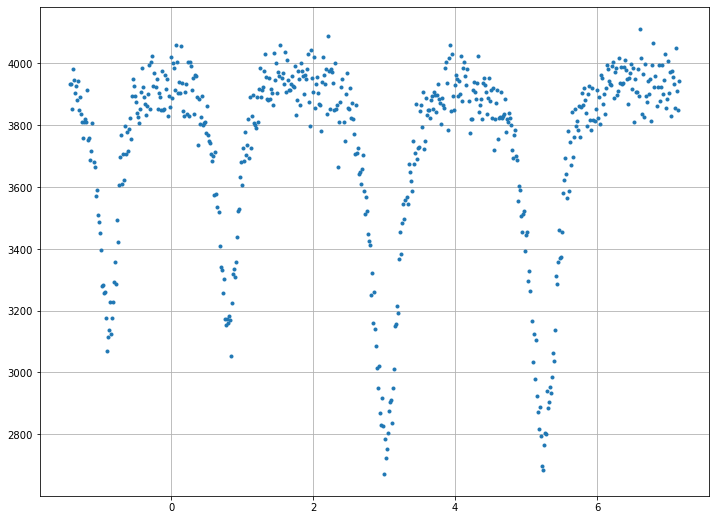

In [235]:
# Expand column index to include Slice of peaks 3&4
Index = list(range(0,600))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');

[[Model]]
    (((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + (Model(lorentzian, prefix='p3_') + Model(lorentzian, prefix='p4_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 600
    # variables        = 15
    chi-square         = 574.843087
    reduced chi-square = 0.98263776
    Akaike info crit   = 4.30047418
    Bayesian info crit = 70.2544190
    R-squared          = 0.96328885
[[Variables]]
    a:            -2.78363311 +/- 0.76238516 (27.39%) (init = -6.263017)
    b:             14.6086045 +/- 5.51015370 (37.72%) (init = 49.85068)
    c:             4003.82324 +/- 8.75765538 (0.22%) (init = 3921.678)
    p1_amplitude: -844.950109 +/- 17.5283821 (2.07%) (init = -861.2086)
    p1_center:     5.23661258 +/- 0.00284273 (0.05%) (init = 5.236344)
    p1_sigma:      0.21624300 +/- 0.00502167 (2.32%) (init = 0.2194095)
    p2_amplitude: -850.214382 +/- 19.1235057 (2.25%) (init = -8

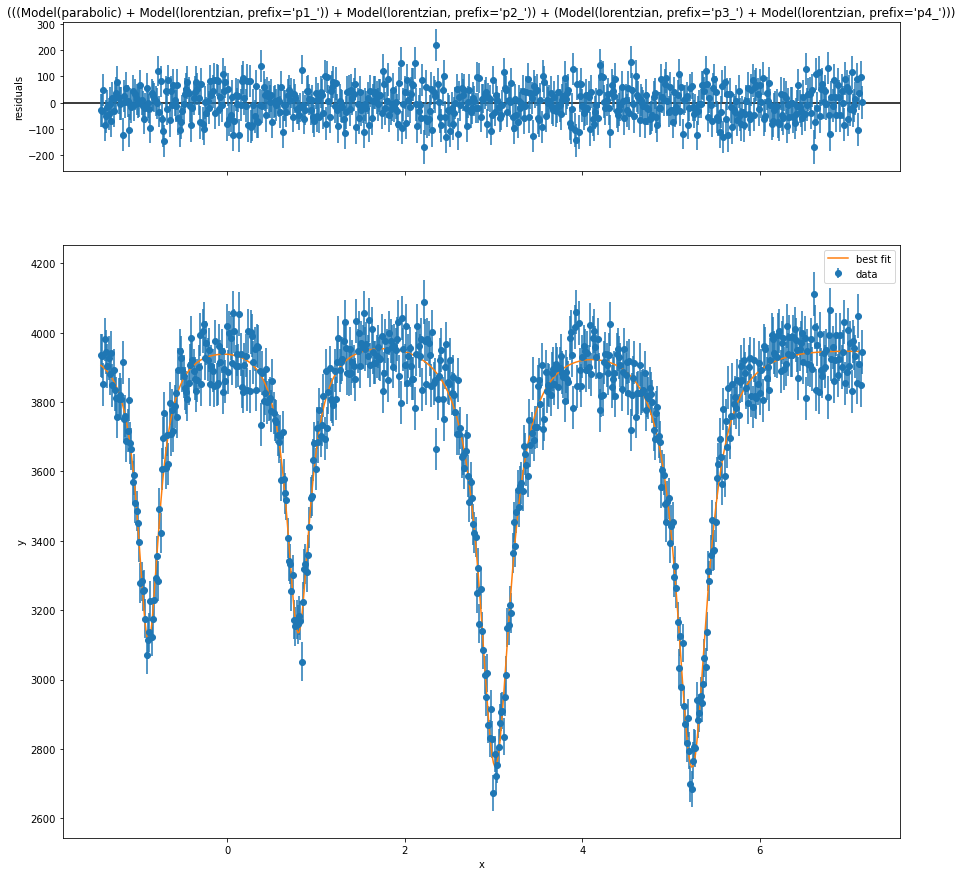

In [236]:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

Name             Value   Stderr     Vary
a               -2.784   0.7624     True
b                14.61     5.51     True
c                 4004    8.758     True
p1_amplitude      -845    17.53     True
p1_center        5.237 0.002843     True
p1_fwhm         0.4325  0.01004    False
p1_height        -1244    15.75    False
p1_sigma        0.2162 0.005022     True
p2_amplitude    -850.2    19.12     True
p2_center        3.018   0.0028     True
p2_fwhm          0.431  0.01043    False
p2_height        -1256    15.91    False
p2_sigma        0.2155 0.005215     True
p3_amplitude    -434.2    14.87     True
p3_center       0.7998 0.003686     True
p3_fwhm          0.322  0.01271    False
p3_height       -858.5    19.16    False
p3_sigma         0.161 0.006356     True
p4_amplitude    -406.8    19.91     True
p4_center      -0.8881 0.003528     True
p4_fwhm         0.2995  0.01455    False
p4_height       -864.6    20.84    False
p4_sigma        0.1498 0.007276     True

Original parame

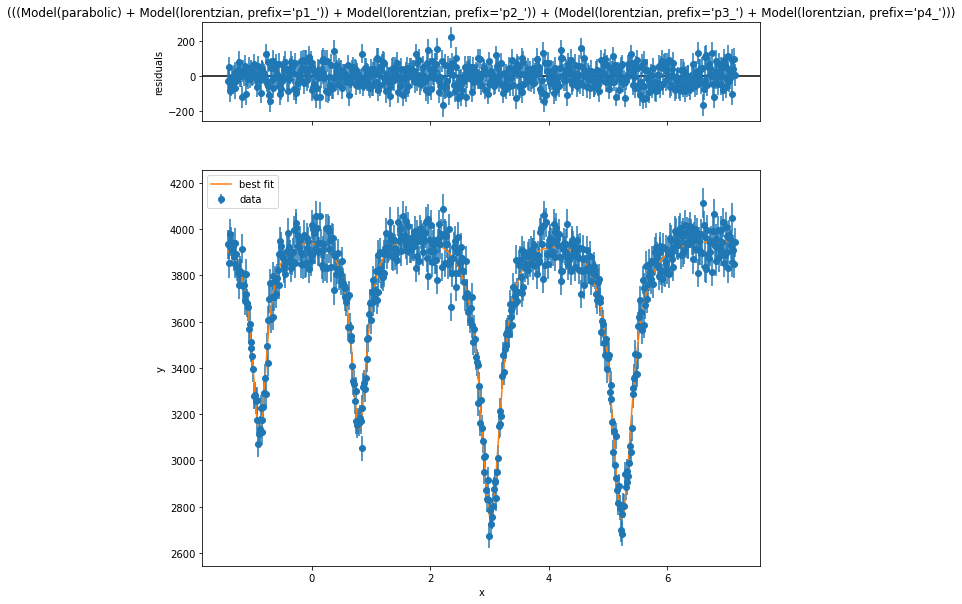

In [237]:
params2 = model_fit.params
params2.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

params2['b'].vary = True
params2['a'].vary = True

model_fit = model.fit(Fe['Counts'][Index], params2, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

#### Add and Fit Slice 3

In [238]:
# Set third set of start parameters
params2 = model_fit.params

model3 = LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

params3 = model3.make_params()

params3['p5_center'].set(value=-3.1, vary=True)
params3['p5_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params3['p5_sigma'].set(value=0.15, vary=True)

params3['p6_center'].set(value=-5.1, vary=True)
params3['p6_amplitude'].set(value=-4000.0*0.15*np.pi, vary=True)
params3['p6_sigma'].set(value=0.15, vary=True)

model = model1 + model2 + model3

params = params1 + params2 + params3

params.pretty_print(columns=['value','stderr','vary'])


Name             Value   Stderr     Vary
a               -2.784   0.7624     True
b                14.61     5.51     True
c                 4004    8.758     True
p1_amplitude    -844.9    17.53     True
p1_center        5.237 0.002843     True
p1_fwhm         0.4325  0.01004    False
p1_height        -1244    15.75    False
p1_sigma        0.2162 0.005022     True
p2_amplitude    -850.2    19.12     True
p2_center        3.018   0.0028     True
p2_fwhm          0.431  0.01043    False
p2_height        -1256    15.91    False
p2_sigma        0.2155 0.005215     True
p3_amplitude    -434.2    14.87     True
p3_center       0.7998 0.003686     True
p3_fwhm          0.322  0.01271    False
p3_height       -858.5    19.16    False
p3_sigma         0.161 0.006356     True
p4_amplitude    -406.8    19.91     True
p4_center      -0.8881 0.003528     True
p4_fwhm         0.2995  0.01455    False
p4_height       -864.6    20.84    False
p4_sigma        0.1498 0.007276     True
p5_amplitude    

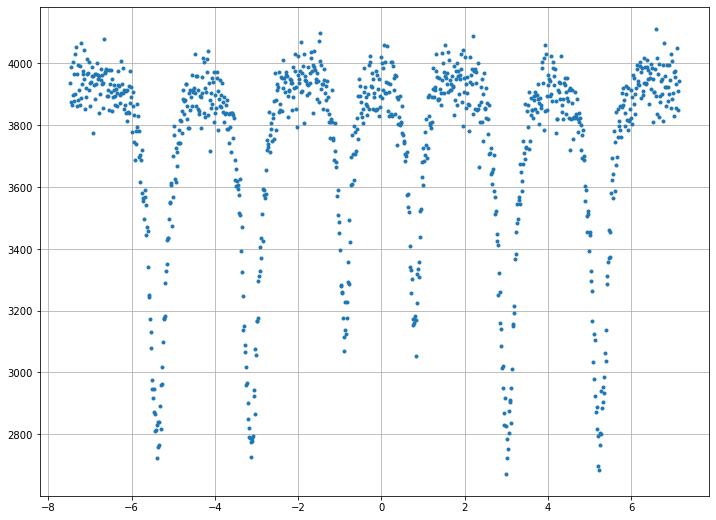

In [239]:
# Expand column index to include Slice of peaks 3&4
Index = list(range(0,1023))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.');

[[Model]]
    ((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + (Model(lorentzian, prefix='p3_') + Model(lorentzian, prefix='p4_'))) + (Model(lorentzian, prefix='p5_') + Model(lorentzian, prefix='p6_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 1023
    # variables        = 21
    chi-square         = 942.866194
    reduced chi-square = 0.94098423
    Akaike info crit   = -41.4465060
    Bayesian info crit = 62.0938841
    R-squared          = 0.96659651
[[Variables]]
    a:            -1.08762068 +/- 0.16773768 (15.42%) (init = -2.783639)
    b:            -0.28642890 +/- 0.68684445 (239.80%) (init = 14.60865)
    c:             4029.93218 +/- 5.70950496 (0.14%) (init = 4003.823)
    p1_amplitude: -832.248420 +/- 15.8592428 (1.91%) (init = -844.95)
    p1_center:     5.23697092 +/- 0.00276077 (0.05%) (init = 5.236613)
    p1_sigma:      0.21369599 +/- 0.00473009 (2.21%) (init = 

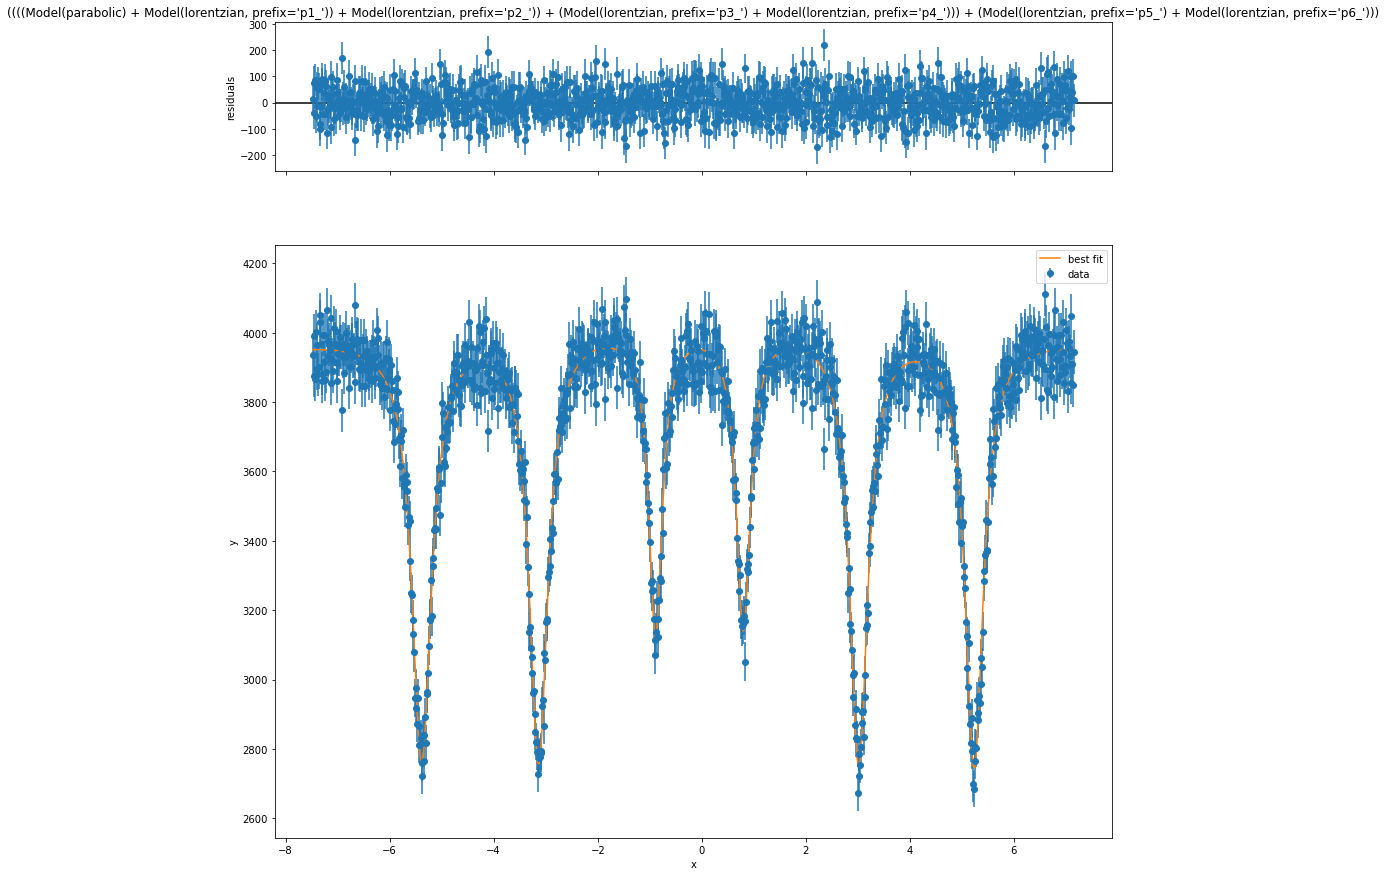

In [240]:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

Name             Value   Stderr     Vary
a               -1.088   0.1677     True
b              -0.2864   0.6868     True
c                 4030     5.71     True
p1_amplitude    -832.2    15.86     True
p1_center        5.237 0.002761     True
p1_fwhm         0.4274  0.00946    False
p1_height        -1240    15.39    False
p1_sigma        0.2137  0.00473     True
p2_amplitude    -838.5    15.05     True
p2_center        3.018 0.002728     True
p2_fwhm         0.4262 0.009061    False
p2_height        -1252    15.41    False
p2_sigma        0.2131 0.004531     True
p3_amplitude    -449.4    13.38     True
p3_center       0.7991 0.003637     True
p3_fwhm         0.3318  0.01191    False
p3_height       -862.2    18.42    False
p3_sigma        0.1659 0.005954     True
p4_amplitude    -439.4    12.99     True
p4_center      -0.8882 0.003469     True
p4_fwhm         0.3172  0.01134    False
p4_height       -881.7    18.78    False
p4_sigma        0.1586  0.00567     True
p5_amplitude    

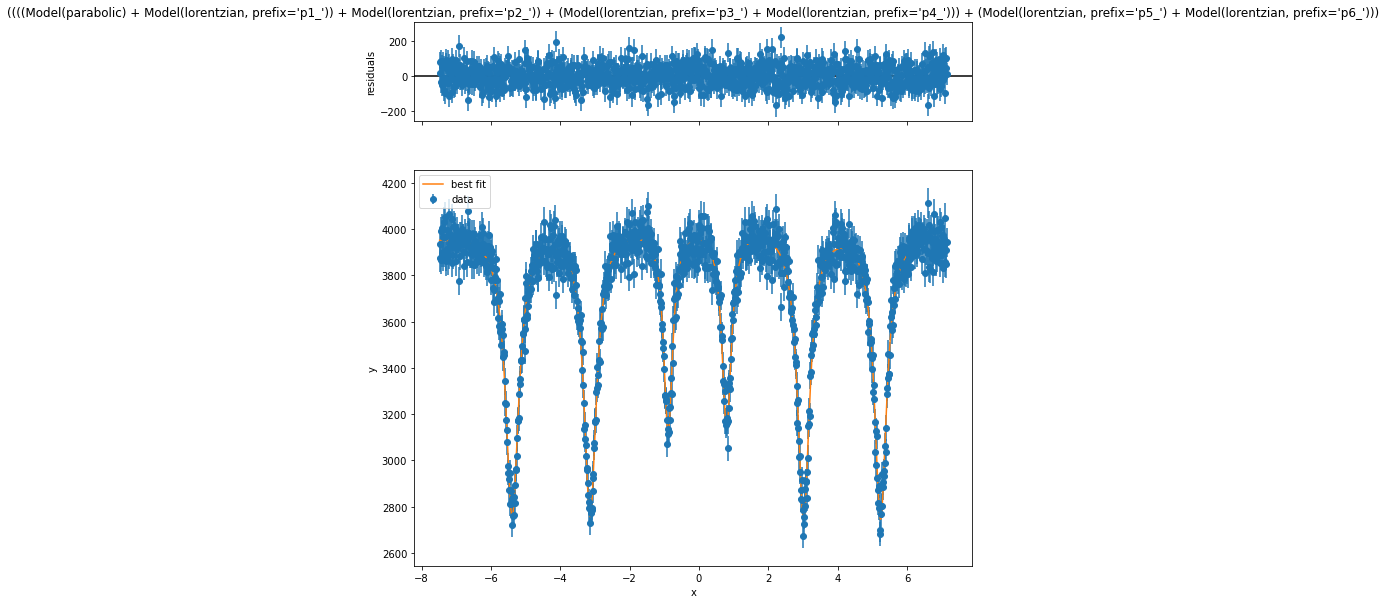

In [241]:
params3 = model_fit.params
params3.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

params3['b'].vary = True
params3['a'].vary = True

model_fit = model.fit(Fe['Counts'][Index], params3, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

### Save the peak centers

When you have obtained the best values, save the peak parameters.  I like to make a dataframe.  Here is one way to iterate over the parameters after they have been saved to extract the peak locations and uncertainties and make a table.

In [242]:
# Save the parameters from the best fit
Fe_params = model_fit.params

Fe_peaks = []
for parm in Fe_params:
    if parm.endswith('center'): 
        Fe_peaks.append(unc.ufloat(Fe_params[parm].value, Fe_params[parm].stderr))
        

In [243]:
Fe_peaks_df = pd.DataFrame()
Fe_peaks_df['Number'] = [1,2,3,4,5,6]
Fe_peaks_df['Location (mm/s)'] = Fe_peaks
Fe_peaks_df

,Number,Location (mm/s)
0,1,5.2370+/-0.0028
1,2,3.0178+/-0.0027
2,3,0.799+/-0.004
3,4,-0.8882+/-0.0035
4,5,-3.1367+/-0.0028
5,6,-5.3857+/-0.0029


## Repeat the above procedure for the other data files.



### Sodium Best-fit Peak Positions

In [244]:
# Read in Data
S = pd.read_csv('Sodium_counts.csv')
S['Chan'] = S['Channel']

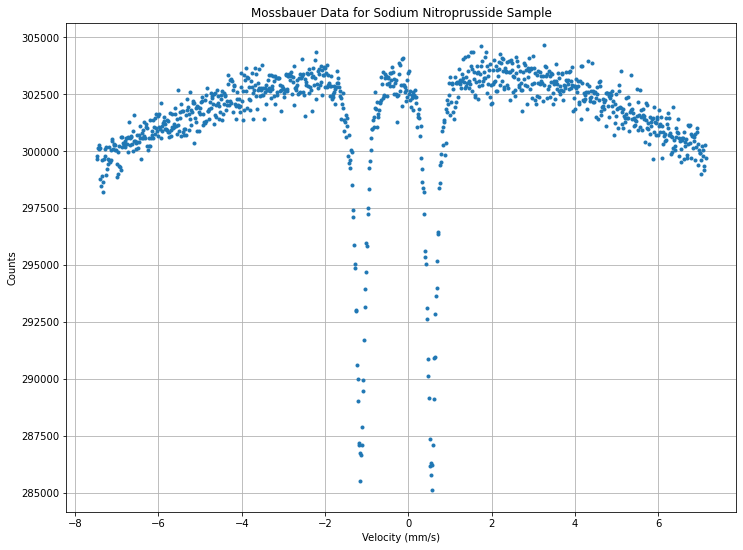

In [245]:
# Create a velocity column
S['velocity'] = velocity_cal(S['Chan'],Vpp=Vpp['Nitroprusside'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Sodium Nitroprusside Sample')
plt.plot(S['velocity'],S['Counts'],'.');

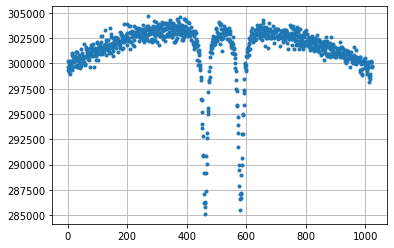

In [246]:
# Plot against column index
plt.grid()
plt.plot(S['Counts'],'.');

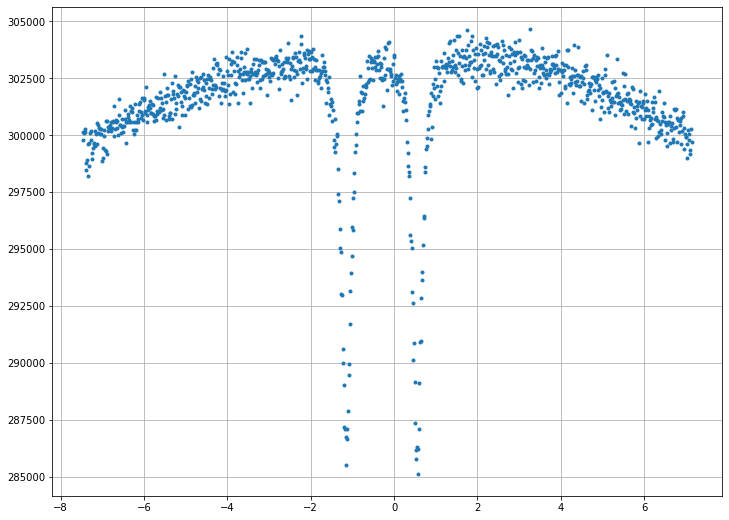

In [247]:
# Plot against velocity array
Index = list(range(0,1023))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(S['velocity'][Index],S['Counts'][Index],'.');

In [248]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
model4 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')

model = model1

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


In [249]:
# Set starting params
params['p1_center'].set(value=0.7, vary=True)
params['p1_amplitude'].set(value=-20000.0*0.15*np.pi, vary=True)
params['p1_sigma'].set(value=0.15, vary=True)

params['p2_center'].set(value=-1, vary=True)
params['p2_amplitude'].set(value=-20000.0*0.15*np.pi, vary=True)
params['p2_sigma'].set(value=0.15, vary=True)


params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 20000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                2e+04     True
p1_amplitude     -9425     True
p1_center          0.7     True
p1_fwhm            0.3    False
p1_height       -2e+04    False
p1_sigma          0.15     True
p2_amplitude     -9425     True
p2_center           -1     True
p2_fwhm            0.3    False
p2_height       -2e+04    False
p2_sigma          0.15     True


[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 1023
    # variables        = 7
    chi-square         = 5171.48690
    reduced chi-square = 5.09004616
    Akaike info crit   = 1671.69044
    Bayesian info crit = 1706.20390
    R-squared          = 0.79448584
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             302201.287 +/- 42.1971058 (0.01%) (init = 20000)
    p1_amplitude: -5370.37922 +/- 169.342634 (3.15%) (init = -9424.778)
    p1_center:     0.55015227 +/- 0.00292585 (0.53%) (init = 0.7)
    p1_sigma:      0.09758702 +/- 0.00424527 (4.35%) (init = 0.15)
    p2_amplitude: -5375.46086 +/- 172.763837 (3.21%) (init = -9424.778)
    p2_center:    -1.15314576 +/- 0.00308693 (0.27%) (init = -1)
    p2_sigma:      0.10115713 +/- 0.00448246 (4.43%) (init = 0.15)
    p1_fwhm:       0.19517404 +

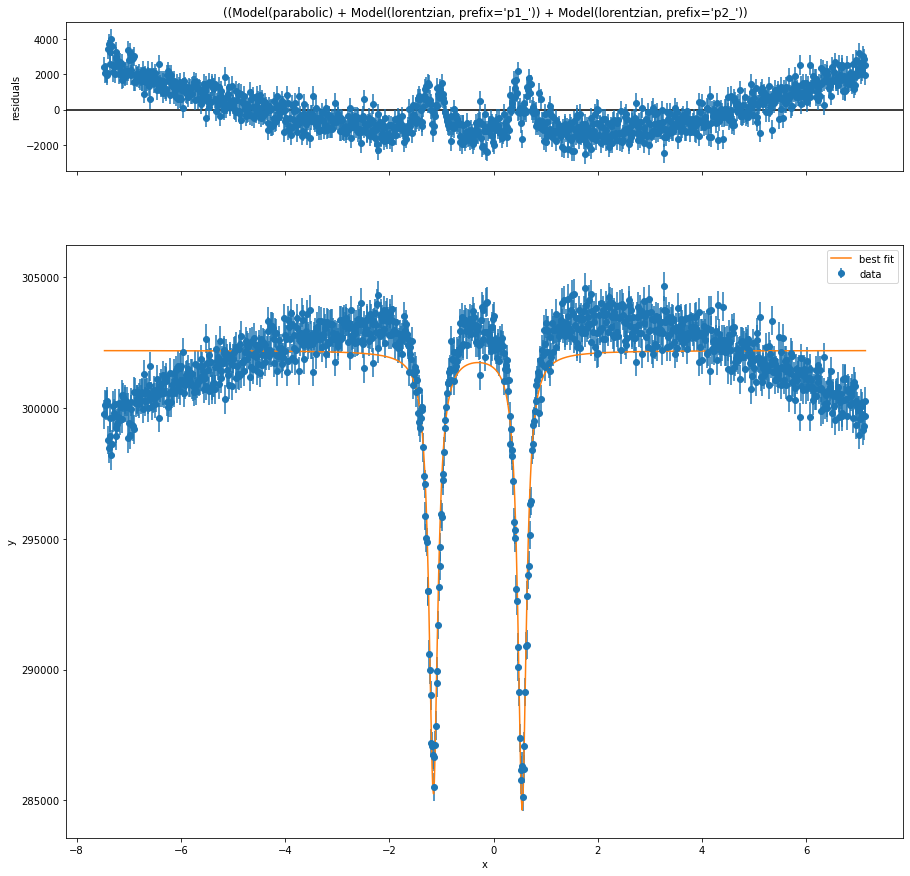

In [250]:
# Fit
model_fit = model.fit(S['Counts'][Index], params, x=S['velocity'], weights=1/np.sqrt(S['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c             3.022e+05     42.2     True
p1_amplitude     -5370    169.3     True
p1_center       0.5502 0.002926     True
p1_fwhm         0.1952 0.008491    False
p1_height     -1.752e+04    522.1    False
p1_sigma       0.09759 0.004245     True
p2_amplitude     -5375    172.8     True
p2_center       -1.153 0.003087     True
p2_fwhm         0.2023 0.008965    False
p2_height     -1.691e+04    513.3    False
p2_sigma        0.1012 0.004482     True

Original parameters (not changed):
Name             Value   Stderr     Vary
a                    0     None    False
b                    0     None    False
c                2e+04     None     True
p1_amplitude     -9425     None     True
p1_center          0.7     None     True
p1_fwhm            0.3     None    False
p1_height       -2e+04     None    False
p1_sigma          0.15     None     True
p2_amplitude    

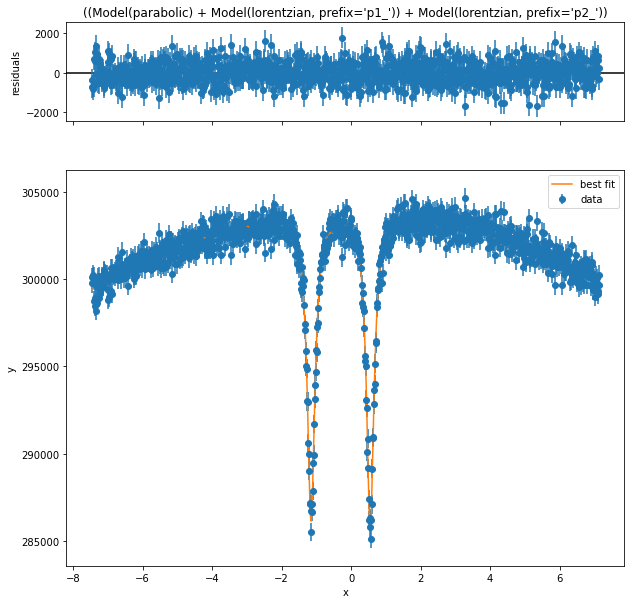

In [251]:
params1 = model_fit.params
params1.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

params1['b'].vary = True
params1['a'].vary = True

model_fit = model.fit(S['Counts'][Index], params1, x=S['velocity'], weights=1/np.sqrt(S['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

In [252]:
# Save the parameters from the best fit
S_params = model_fit.params

S_peaks = []
for parm in S_params:
    if parm.endswith('center'): 
        S_peaks.append(unc.ufloat(S_params[parm].value, S_params[parm].stderr))

In [253]:
# Save to dataframe
S_peaks_df = pd.DataFrame()
S_peaks_df['Number'] = [1,2]
S_peaks_df['Location (mm/s)'] = S_peaks
S_peaks_df

,Number,Location (mm/s)
0,1,0.5502+/-0.0014
1,2,-1.1530+/-0.0015


### Steel Best-Fit Peak Positions

In [254]:
# Read in Data
Steel = pd.read_csv('Steel_counts.csv')
Steel['Chan'] = Steel['Channel']

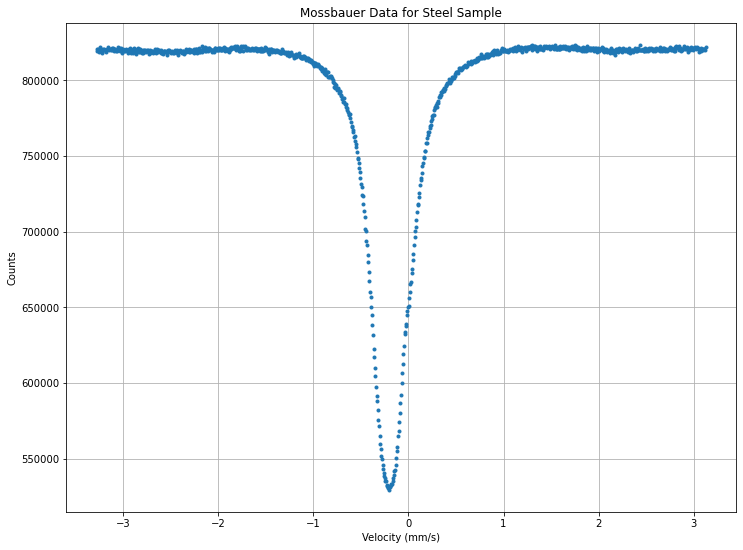

In [255]:
# Create a velocity column
Steel['velocity'] = velocity_cal(Steel['Chan'],Vpp=Vpp['Fe2O3'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Steel Sample')
plt.plot(Steel['velocity'],Steel['Counts'],'.');

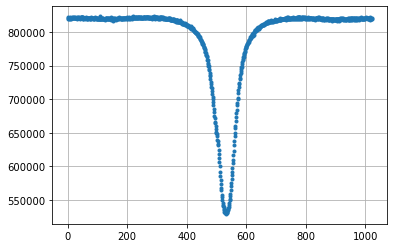

In [256]:
# Plot against column index
plt.grid()
plt.plot(Steel['Counts'],'.');

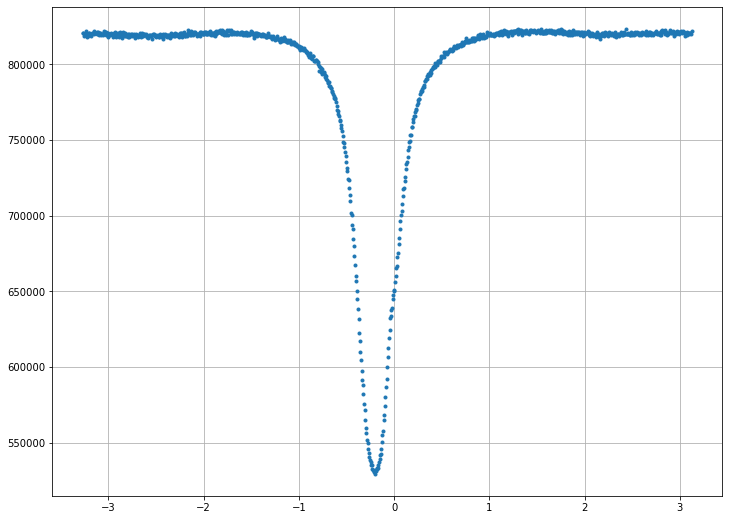

In [257]:
# Plot against velocity array
Index = list(range(0,1023))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Steel['velocity'][Index],Steel['Counts'][Index],'.');

In [ ]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
model5 = QuadraticModel() + LorentzianModel(prefix='p1_')

model = model5

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

In [261]:
# Set starting params
params['p1_center'].set(value=-0.2, vary=True)
params['p1_amplitude'].set(value=-300000.0*0.15*np.pi, vary=True)
params['p1_sigma'].set(value=0.15, vary=True)


params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 300000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                3e+05     True
p1_amplitude  -1.414e+05     True
p1_center         -0.2     True
p1_fwhm            0.3    False
p1_height       -3e+05    False
p1_sigma          0.15     True
p2_amplitude     -9425     True
p2_center           -1     True
p2_fwhm            0.3    False
p2_height       -2e+04    False
p2_sigma          0.15     True


[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6024
    # data points      = 1023
    # variables        = 7
    chi-square         = 6925.90358
    reduced chi-square = 6.81683423
    Akaike info crit   = 1970.51721
    Bayesian info crit = 2005.03067
    R-squared          = 0.99876548
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             821211.963 +/- 124.409896 (0.02%) (init = 300000)
    p1_amplitude: -44184129.8 +/- 8.9415e+09 (20236.81%) (init = -141371.7)
    p1_center:    -0.22005328 +/- 0.02170215 (9.86%) (init = -0.2)
    p1_sigma:      0.33433383 +/- 0.10834126 (32.41%) (init = 0.15)
    p2_amplitude:  44015566.2 +/- 8.9415e+09 (20314.31%) (init = -9424.778)
    p2_center:    -0.22026910 +/- 0.02220618 (10.08%) (init = -1)
    p2_sigma:      0.33539865 +/- 0.10808941 (32.23%) (init = 0.15)
    p1_fwhm:    

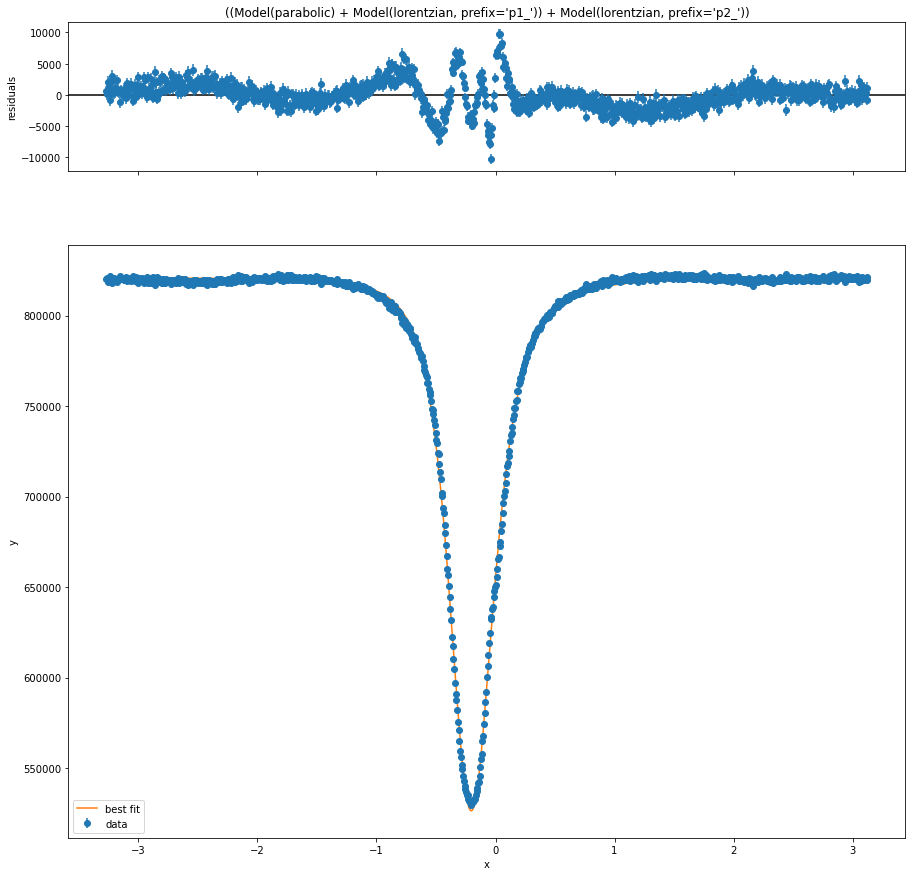

In [262]:
# Fit
model_fit = model.fit(Steel['Counts'][Index], params, x=Steel['velocity'], weights=1/np.sqrt(Steel['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig);

Name             Value   Stderr     Vary
a               -137.1    7.128     True
b               -15.98     15.6     True
c             3.065e+05    267.4     True
p1_amplitude  2.093e+07      nan     True
p1_center       -0.296  0.01507     True
p1_fwhm          1.465        0    False
p1_height     9.095e+06        0    False
p1_sigma        0.7325      nan     True
p2_amplitude  -2.097e+07      nan     True
p2_center       -0.296  0.01507     True
p2_fwhm          1.468        0    False
p2_height     -9.097e+06        0    False
p2_sigma        0.7339      nan     True

Original parameters (not changed):
Name             Value   Stderr     Vary
a                    0     None    False
b                    0     None    False
c                3e+05     None     True
p1_amplitude  -1.414e+05     None     True
p1_center         -0.2     None     True
p1_fwhm            0.3     None    False
p1_height       -3e+05     None    False
p1_sigma          0.15     None     True
p2_amplitude

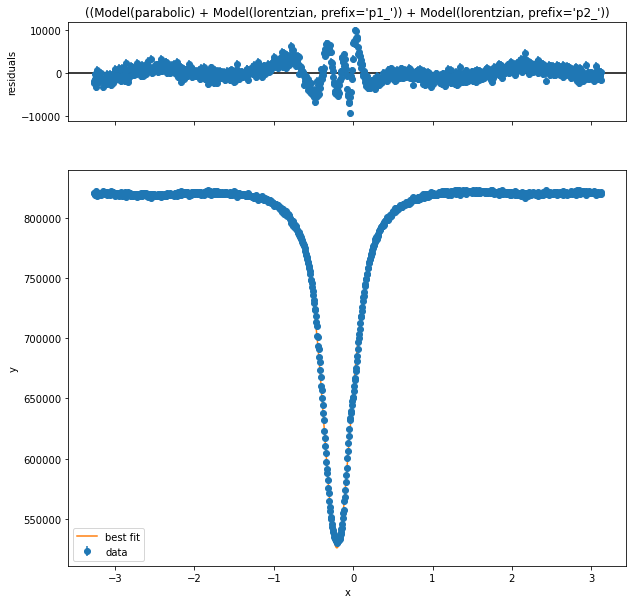

In [264]:
params1 = model_fit.params
params1.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

params1['b'].vary = True
params1['a'].vary = True

model_fit = model.fit(Steel['Counts'][Index], params1, x=Steel['velocity'], weights=1/np.sqrt(Steel['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

In [267]:
# Save the parameters from the best fit
Steel_params = model_fit.params

Steel_peaks = []
for parm in Steel_params:
    if parm.endswith('center'): 
        Steel_peaks.append(unc.ufloat(Steel_params[parm].value, Steel_params[parm].stderr))

In [269]:
# Save to dataframe
Steel_peaks_df = pd.DataFrame()
Steel_peaks_df['Number'] = [1,2]
Steel_peaks_df['Location (mm/s)'] = Steel_peaks
Steel_peaks_df

,Number,Location (mm/s)
0,1,-0.2246+/-0.0011
1,2,-0.2246+/-0.0011


## Calculate final results

Carry out the analysis below that is relevant to your sample types

### Enriched iron and Natural iron

1. Start with isomer shift $\delta$. This is just the average of all peak locations. The number would be relative to the source Co-57/Rh

2. Next calculate the magnetic field $B$ and excited-state moment $\mu_e$ from the enriched-foil data.  

For the field, we first need the transitions that start from different ground states and end at the same excited states.  There are two pairs of these, one pair ends at -1/2: peaks 2 & 4, and the other ends at +1/2, peaks 1 and 3. The differences between these will give $\mu_gB$.  From this get $B$ with $\mu_g = +0.09062\mu_n$ where $\mu_n = 3.1525\times10^{-8}$ eV/T 

You will need to convert to energy with Doppler formula
$$\frac{\Delta E}{E} = \frac{v}{c}$$
where $E = 14.412497$ keV.

To get the excited state moment, you will need the excited state splitting. These pairs that start at the same ground state but end at different excited states: peaks 0-1, 1-2, 3-4, and 4-5.

3. From this calculate the excited state moment $\mu_e$, and compare to $-0.1549\mu_n$. 

4. Repeat the above for any other natural iron samples you may have. (Don't forget to apply the correct calibration constant for each one.)

### Sodium nitroprusside

Need isomer shift relative to Fe foil and quadrupole split, both in mm/s units.

Compare results to literature values of $-0.257$ mm/s for the isomer shift, relative to Fe and $1.7048$ mm/s for the quadrupole splitting.  

### Stainless steel

There is only one peak for the stainless-steel sample, so the only task is to obtain the isomer shift $\delta$. From the referece work by Greenwood and Gibb, typical shifts relative to natural iron are $-0.09$ mm/s with a range between $-0.077$ to $-0.096$ mm/s depending on the alloy type.

Also find the width of the peak and study the following:
* How does the width of the single peak compare to the width of one peak for enriched iron?  Is there evidence of a weak internal field?
* How well does the Lorentzian peak shape fit for stainless?  If it does not fit as well, what could be the reason(s)?

### Hematite (Rust)

Analysis proceeds in same manner as for enriched Fe foil. Find $\delta$, $B$, $\mu_e$. 

#### Then find quadrupole splitting

From Figure 2 in Kistner & Sunyar (PRL Vol. 4, p.412, 1960) peaks 0-1 are closer together than 1-2 by $2\varepsilon$ and peaks 4-5 are farther apart than peaks 3-4.  To find $\varepsilon$ we note that (4-5)-(0-1) should be equal to $4\varepsilon$.

Compare to following results in Kistner & Sunyar:
* G.S Splitting = $6.11\pm0.05$ mm/s
* E.S. splitting = $3.45\pm0.03$ mm/s
* Isomer shift relative to Fe = $0.47\pm0.03$ mm/s
* Quadrupole splitting $\varepsilon = 0.12\pm0.03$ mm/s